<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/CatVsDog/CatVsDog%20-%20TFDS%20Color%20Binary%20Image%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CatVsDog - TFDS Color Binary Image Classification Example

This notebook demonstrates the **Universal ML Workflow** for binary image classification using TensorFlow Datasets.

## Learning Objectives

By the end of this notebook, you will be able to:
- Load image datasets from TensorFlow Datasets
- Apply binary classification to image data
- Preprocess color images: Resize -> Grayscale -> Flatten -> Normalize
- Compare binary image classification with multi-class approaches

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [TensorFlow Datasets - cats_vs_dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) |
| **Problem Type** | Binary Classification (Cat vs Dog) |
| **Data Balance** | Nearly Balanced |
| **Total Images** | ~23,000 images |
| **Preprocessing** | Resize to 32x32 -> Grayscale -> Flatten (1024 features) |

---

## 1. Defining the Problem and Assembling a Dataset

**Problem:** Classify images as either cats or dogs - a classic binary image classification task.

**Why this dataset?** Cats vs. Dogs is one of the most well-known binary image classification benchmarks. It's challenging because:
- High intra-class variation (many breeds, poses, backgrounds)
- Requires distinguishing subtle features between two similar-looking animals

## 2. Choosing a Measure of Success

Accuracy, Precision, Recall, and AUC for binary classification evaluation.

## 3. Deciding on an Evaluation Protocol

Hold-out test + validation + K-fold cross-validation.

## 4. Preparing Your Data

### 4.1 Import Libraries and Load TFDS Dataset

In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow_datasets as tfds
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET = 'cats_vs_dogs'
RESIZE = (32, 32, 3)
GRAY_SCALE = True

In [3]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']
    
    image, label = image.numpy(), label.numpy()
    
    image = resize(image, RESIZE, anti_aliasing=True)
            
    if GRAY_SCALE :
        image = rgb2gray(image)
        
    images.append( image )
    labels.append( label )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXQKKC5/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# list of images to numpy array
X = np.array(images)

# flatten 2D image array to 1D array
X = X.reshape( (X.shape[0], -1) )

# binary output, 0 or 1
y = np.array(labels)

In [5]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, 
                                                    random_state=SEED, shuffle=True)

In [6]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [7]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

## 5. Developing a Model That Does Better Than a Baseline

Baseline for balanced binary classification: 50% accuracy (random guessing).

In [8]:
# number of samples per each class
# we consider this to be a balanced class since the counts are about the same
np.sum(y), len(y)-np.sum(y)

(11604, 11658)

In [9]:
# the class is off-balanced, but very minimal 
baseline = (len(y)-np.sum(y)) / len(y)

baseline

0.5011606912561258

In [10]:
balanced_accuracy_baseline = balanced_accuracy_score(y_train, np.ones(len(y_train)))

balanced_accuracy_baseline

0.5

In [13]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [ ]:
learning_rate = 0.005

# Single Layer Perceptron (no hidden layers) - inline Sequential model
slp_model = Sequential(name='Single_Layer_Perceptron')
slp_model.add(Dense(1, activation='sigmoid', input_shape=(INPUT_DIMENSION,)))
slp_model.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                  loss=LOSS_FUNC, metrics=METRICS)

slp_model.summary()

In [ ]:
batch_size = 128
EPOCHS = 500

In [16]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 0.9976410036457216, 1: 1.002370178840767}

In [ ]:
# Train the SLP model inline
slp_history = slp_model.fit(X_train, y_train, class_weight=CLASS_WEIGHTS, 
                            batch_size=batch_size, epochs=EPOCHS, 
                            validation_data=(X_val, y_val), verbose=0)
slp_val_score = slp_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(slp_val_score[0], baseline))
print('Precision (Validation): {:.2f}'.format(slp_val_score[1]))
print('Recall (Validation): {:.2f}'.format(slp_val_score[2]))
print('AUC (Validation): {:.2f}'.format(slp_val_score[3]))

In [ ]:
preds = slp_model.predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

In [20]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

In [ ]:
plot_training_history(slp_history, monitors=['loss', 'auc'])

## 6. Scaling Up: Developing a Model That Overfits

Adding hidden layers to learn distinguishing features between cats and dogs.

In [ ]:
learning_rate = 0.001

# Multi-Layer Perceptron (1 hidden layer) - inline Sequential model
mlp_model = Sequential(name='Multi_Layer_Perceptron')
mlp_model.add(Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)))
mlp_model.add(Dense(1, activation='sigmoid'))
mlp_model.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                  loss=LOSS_FUNC, metrics=METRICS)

mlp_model.summary()

In [ ]:
# Train the MLP model inline
mlp_history = mlp_model.fit(X_train, y_train, class_weight=CLASS_WEIGHTS, 
                            batch_size=batch_size, epochs=EPOCHS, 
                            validation_data=(X_val, y_val), verbose=0)
mlp_val_score = mlp_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
plot_training_history(mlp_history, monitors=['loss', 'auc'])

In [ ]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(mlp_val_score[0], baseline))
print('Precision (Validation): {:.2f}'.format(mlp_val_score[1]))
print('Recall (Validation): {:.2f}'.format(mlp_val_score[2]))
print('AUC (Validation): {:.2f}'.format(mlp_val_score[3]))

## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [ ]:
# Hyperband Model Builder for Binary Classification
def build_model_hyperband(hp):
    """
    Build CatVsDog model with FROZEN architecture (2 layers: 64 -> 32 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 64 and 32 neurons
    # Layer 1: 64 neurons
    model.add(layers.Dense(64, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 32 neurons
    model.add(layers.Dense(32, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for binary classification
    model.add(layers.Dense(OUTPUT_DIMENSION, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_auc',
    max_epochs=20,
    factor=3,
    directory='catvsdog_hyperband',
    project_name='catvsdog_tuning'
)

# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS
)

In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

In [ ]:
# Train the best model
opt_history = opt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)
opt_val_score = opt_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(opt_val_score[0], baseline))
print('Precision (Validation): {:.2f}'.format(opt_val_score[1]))
print('Recall (Validation): {:.2f}'.format(opt_val_score[2]))
print('AUC (Validation): {:.2f}'.format(opt_val_score[3]))

In [ ]:
preds = opt_model.predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test, (preds > 0.5).astype('int32')), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

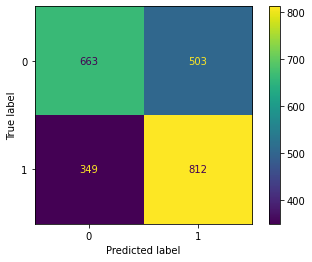

In [54]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
_ = disp.plot()

---

## 8. Key Takeaways

1. **Binary Image Classification:** Same preprocessing pipeline (resize, grayscale, flatten) as multi-class
2. **Output Layer:** Single neuron with sigmoid activation for binary
3. **Loss:** Binary cross-entropy
4. **Dense networks struggle** with complex image features - CNNs would perform better

---

## Appendix: Modular Helper Functions

The following reusable functions encapsulate common patterns for building and training neural networks. These are provided for reference and can be used in other projects.

In [ ]:
# Modular MLP Model Builder
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None):
    """
    Build a configurable deep neural network for binary or multi-class classification.
    
    Parameters:
    -----------
    hidden_layers : int
        Number of hidden layers (0 for single-layer perceptron)
    hidden_neurons : int
        Number of neurons per hidden layer
    activation : str
        Activation function for hidden layers (e.g., 'relu')
    dropout : float
        Dropout rate (0.0-1.0), use np.nan to disable
    input_dimension : int
        Number of input features
    output_dimension : int
        Number of output classes (1 for binary, >1 for multi-class)
    optimizer : str or optimizer instance
        Optimizer for training
    loss : str
        Loss function
    metrics : list
        Metrics to track during training
    name : str
        Model name
    
    Returns:
    --------
    keras.Sequential : Compiled model
    """
    model = Sequential()
    for layer in range(hidden_layers):
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer > 0 else (input_dimension,)))
        if not np.isnan(dropout):
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension == 1 else 'softmax',
                    input_shape='default' if hidden_layers > 0 else (input_dimension,)))
  
    if name is not None:
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


# Modular Training Function
def train_deep_neural_network(model, X, y, class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0):
    """
    Train a deep neural network with validation.
    
    Parameters:
    -----------
    model : keras.Model
        Compiled Keras model
    X : np.array
        Training features
    y : np.array
        Training labels
    class_weights : dict
        Class weights for imbalanced data
    batch_size : int
        Batch size for training
    epochs : int
        Number of training epochs
    val_data : tuple
        (X_val, y_val) validation data
    callbacks : list
        Keras callbacks
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    tuple : (model, val_score, history)
    """
    if val_data is None:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
    else:
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)
    
    val_score = model.evaluate(X_val, y_val, verbose=0)[1:]

    return model, val_score, history


# Example Usage (commented out):
# 
# # Build a model with 1 hidden layer
# model = deep_neural_network(
#     hidden_layers=1, 
#     hidden_neurons=64,
#     activation='relu',
#     dropout=0.2,
#     input_dimension=INPUT_DIMENSION, 
#     output_dimension=OUTPUT_DIMENSION,
#     optimizer=RMSprop(learning_rate=0.001), 
#     loss='binary_crossentropy',
#     metrics=METRICS,
#     name='My_Model'
# )
#
# # Train the model
# trained_model, val_score, history = train_deep_neural_network(
#     model, X_train, y_train,
#     class_weights=CLASS_WEIGHTS,
#     batch_size=128, 
#     epochs=500, 
#     val_data=(X_val, y_val)
# )
#
# # Evaluate
# print(f'Accuracy: {val_score[0]:.2f}')